In [2]:
!git clone https://github.com/rajeevratan84/image-segmentation-keras.git

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Cloning into 'image-segmentation-keras'...
remote: Enumerating objects: 1165, done.
remote: Total 1165 (delta 0), reused 0 (delta 0), pack-reused 1165
Receiving objects: 100% (1165/1165), 3.29 MiB | 35.83 MiB/s, done.
Resolving deltas: 100% (752/752), done.


In [3]:
%cd image-segmentation-keras
# !python setup.py install

/kaggle/working/image-segmentation-keras


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
from keras.callbacks import ModelCheckpoint
from IPython.display import Image
import tensorflow as tf
from tensorflow.keras import backend as K
from keras_segmentation.models.unet import vgg_unet, resnet50_unet
from tensorflow.keras.optimizers import Adam
import time

In [5]:
import tensorflow as tf

from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Input
from tensorflow.keras.models import Model

In [6]:
image_train_list = os.listdir('/kaggle/input/drive-auto/images_prepped_train')
anns_train_list = os.listdir('/kaggle/input/drive-auto/annotations_prepped_train')
image_val_list = os.listdir('/kaggle/input/drive-auto/images_prepped_test')
anns_val_list = os.listdir('/kaggle/input/drive-auto/annotations_prepped_test')

print('number of train data pairs: ', len(set(image_train_list).intersection(anns_train_list)))
print('number of validation data pairs: ', len(set(image_val_list).intersection(anns_val_list)))
del image_train_list, anns_train_list, image_val_list, anns_val_list

number of train data pairs:  367
number of validation data pairs:  101


In [7]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    """
    Calculate Dice Loss between the ground truth and predictions.

    Parameters:
    - y_true: Ground truth labels (shape: [batch_size, height, width, num_classes])
    - y_pred: Predicted labels (shape: [batch_size, height, width, num_classes])
    - smooth: Smoothing factor to avoid division by zero

    Returns:
    - Dice Loss value
    """
    # Flatten the tensors
    y_true_f = K.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = K.flatten(y_pred)

    # Calculate intersection and union
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)

    # Compute Dice coefficient
    dice = (2. * intersection + smooth) / (union + smooth)

    # Return Dice Loss
    return 1 - dice

In [8]:
model = vgg_unet(n_classes=30, input_height=352, input_width=480)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
def custom_augmentation():
    return iaa.Sequential(
        [
            # apply the following augmenters to most images
#             iaa.GaussianBlur(sigma=(0.0, 0.5)),
            iaa.Fliplr(0.5), # horizontally flip 50% of all images
            iaa.GammaContrast((0.5, 2.0)),
            iaa.convolutional.Sharpen(alpha=(0.0, 0.2), lightness=(0.8, 1.2))
#             iaa.Grayscale(alpha=(0.0, 1.0)),
#             iaa.pillike.FilterFindEdges(),
#             iaa.ShearX((-20, 20)),
#             iaa.AdditiveGaussianNoise(scale=(0, 0.1*255)),
#             iaa.Canny(alpha=(0.0, 0.5),colorizer=iaa.RandomColorsBinaryImageColorizer(color_true=255,color_false=0)),
        ])
# [sharpness, contrast], blur (jgn terlalu blur), saturation, hue

def image_preprocessing(image):
    image = tf.cast(image, tf.float32)
    scaled_image = image.numpy() / 255.0
    return scaled_image

In [10]:
from keras_segmentation.data_utils.data_loader import image_segmentation_generator, verify_segmentation_dataset
train_gen = image_segmentation_generator(images_path = "/kaggle/input/drive-auto/images_prepped_train",
                                         segs_path = "/kaggle/input/drive-auto/annotations_prepped_train",
                                         batch_size = 2,  
                                         n_classes = 30,
                                         input_height = 352, 
                                         input_width = 480, 
                                         output_height = model.output_height, 
                                         output_width = model.output_width,
                                         do_augment=False, 
#                                          augmentation_name=augmentation_name,
#                                          custom_augmentation=custom_augmentation, 
#                                          other_inputs_paths=other_inputs_paths,
#                                          preprocessing=image_preprocessing, 
                                         read_image_type=1)

val_gen = image_segmentation_generator(images_path = "/kaggle/input/drive-auto/images_prepped_test",
                                       segs_path = "/kaggle/input/drive-auto/annotations_prepped_test",  
                                       batch_size = 2,
                                       n_classes = 30, 
                                       input_height = 352, 
                                       input_width = 480, 
                                       output_height = model.output_height, 
                                       output_width = model.output_width,
                                       do_augment = False,
#                                          augmentation_name=augmentation_name,
#                                          custom_augmentation=custom_augmentation, 
#                                          other_inputs_paths=other_inputs_paths,
#                                          preprocessing=image_preprocessing, 
                                       read_image_type=1)

In [11]:
verify_segmentation_dataset(images_path = "/kaggle/input/drive-auto/images_prepped_train",
                            segs_path = "/kaggle/input/drive-auto/annotations_prepped_train",
                            n_classes = 30)
verify_segmentation_dataset(images_path = "/kaggle/input/drive-auto/images_prepped_test",
                            segs_path = "/kaggle/input/drive-auto/annotations_prepped_test",
                            n_classes = 30)

100%|██████████| 367/367 [00:05<00:00, 62.52it/s]


Dataset verified! 


100%|██████████| 101/101 [00:01<00:00, 60.40it/s]

Dataset verified! 


True

In [12]:
checkpoint_path = "/kaggle/working/weights/vgg_unet.weights.h5"
os.makedirs(os.path.dirname(checkpoint_path), exist_ok = True)
checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor="val_dice_loss",
                             save_best_only=False,
                             save_weights_only = True,
                             mode="min")

In [13]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',#dice_loss,
    metrics=[dice_loss, 'accuracy']#, tf.keras.metrics.F1Score(average = "weighted")] # f1-score, accuracy
)

start_time = time.time()
model.fit(train_gen,
          steps_per_epoch = 512,
          validation_data=val_gen,
          validation_steps=512,
          epochs = 10, # coba 20 epoch u/ cek overfitting
          callbacks=[checkpoint],
          initial_epoch=0)
print('training completed in {} s'.format(time.time()-start_time))

Epoch 1/10


I0000 00:00:1722519984.596990     120 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


512/512 ━━━━━━━━━━━━━━━━━━━━ 163s 208ms/step - accuracy: 0.5820 - dice_loss: 0.6042 - loss: 1.7743 - val_accuracy: 0.7254 - val_dice_loss: 0.4107 - val_loss: 0.9609
Epoch 2/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 105s 205ms/step - accuracy: 0.8242 - dice_loss: 0.2671 - loss: 0.6155 - val_accuracy: 0.8328 - val_dice_loss: 0.2642 - val_loss: 0.5878
Epoch 3/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 105s 205ms/step - accuracy: 0.8640 - dice_loss: 0.2048 - loss: 0.4584 - val_accuracy: 0.8383 - val_dice_loss: 0.2420 - val_loss: 0.5412
Epoch 4/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 104s 204ms/step - accuracy: 0.8921 - dice_loss: 0.1616 - loss: 0.3571 - val_accuracy: 0.8708 - val_dice_loss: 0.1748 - val_loss: 0.4086
Epoch 5/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 104s 203ms/step - accuracy: 0.9065 - dice_loss: 0.1389 - loss: 0.3030 - val_accuracy: 0.8384 - val_dice_loss: 0.1967 - val_loss: 0.5416
Epoch 6/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 103s 201ms/step - accuracy: 0.9208 - dice_loss: 0.1175 - loss: 0.2503 - val_accuracy: 0.823

In [14]:
print(model.history.history.keys())

dict_keys(['accuracy', 'dice_loss', 'loss', 'val_accuracy', 'val_dice_loss', 'val_loss'])


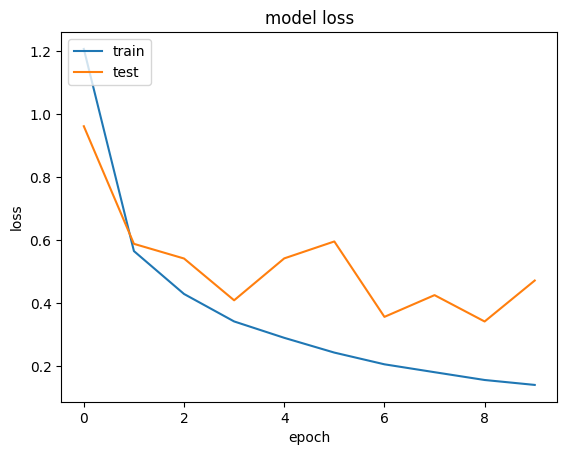

In [15]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

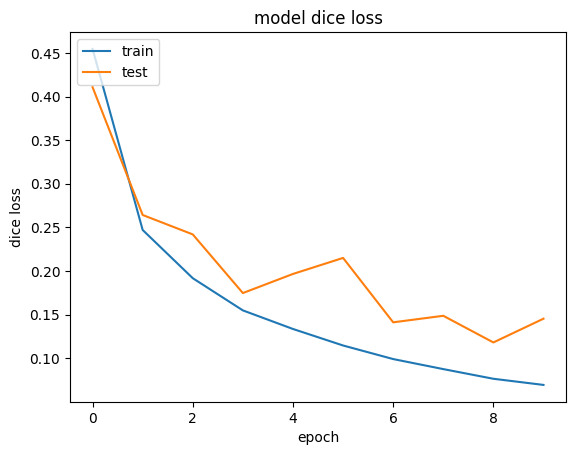

In [16]:
plt.plot(model.history.history['dice_loss'])
plt.plot(model.history.history['val_dice_loss'])
plt.title('model dice loss')
plt.ylabel('dice loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

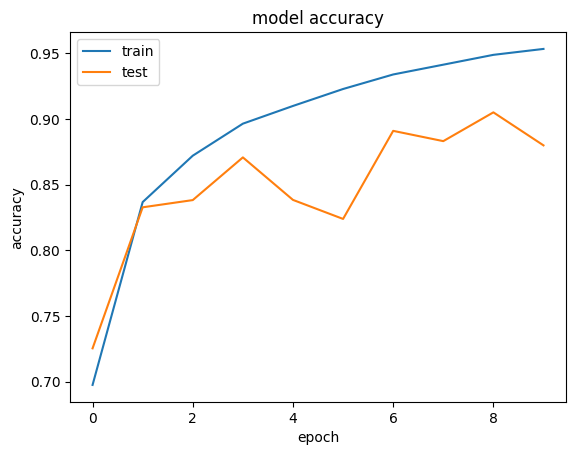

In [17]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# plt.plot(model.history.history['loss'])
# plt.plot(model.history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


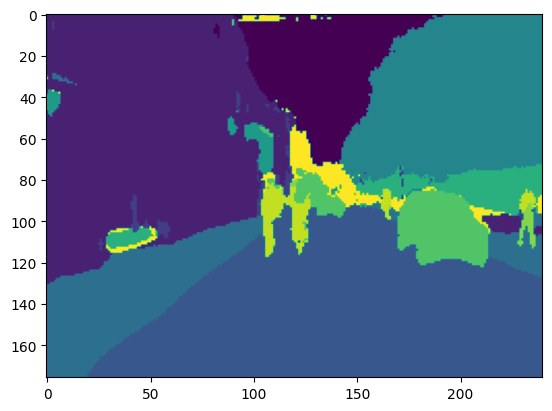

In [19]:
out = model.predict_segmentation(
    inp = "/kaggle/input/drive-auto/images_prepped_test/0016E5_07959.png"
)
plt.imshow(out)

In [20]:
from IPython.display import Image

o = model.predict_segmentation(
    inp="/kaggle/input/drive-auto/images_prepped_test/0016E5_07959.png",
    out_fname="/kaggle/working/out2.png",
    overlay_img=True,
    show_legends=True,
    class_names = ["Sky","Building","Pole","Road","pavement","Tree","SignSymbol","Fence","Car","Pedestrian","Bicylist"]
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
